<a href="https://colab.research.google.com/github/machadoleonardo94/smog-alado/blob/main/Safeboat_plotter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install libraries
!pip install folium requests

In [4]:
# Patrick test data
#import requests
#url = "https://gist.githubusercontent.com/patrickelectric/073cc5a53822fa6ad7c01e81cf470852/raw/bff16543fd594389c46701f35076aed7f1955a32/leolog.json"
#response = requests.get(url)
#data = response.json()

import json
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

with open(filename, 'r') as f:
    data = json.load(f)

Saving navalcare-connect-app-default-rtdb-24-11-04-export(1).json to navalcare-connect-app-default-rtdb-24-11-04-export(1).json


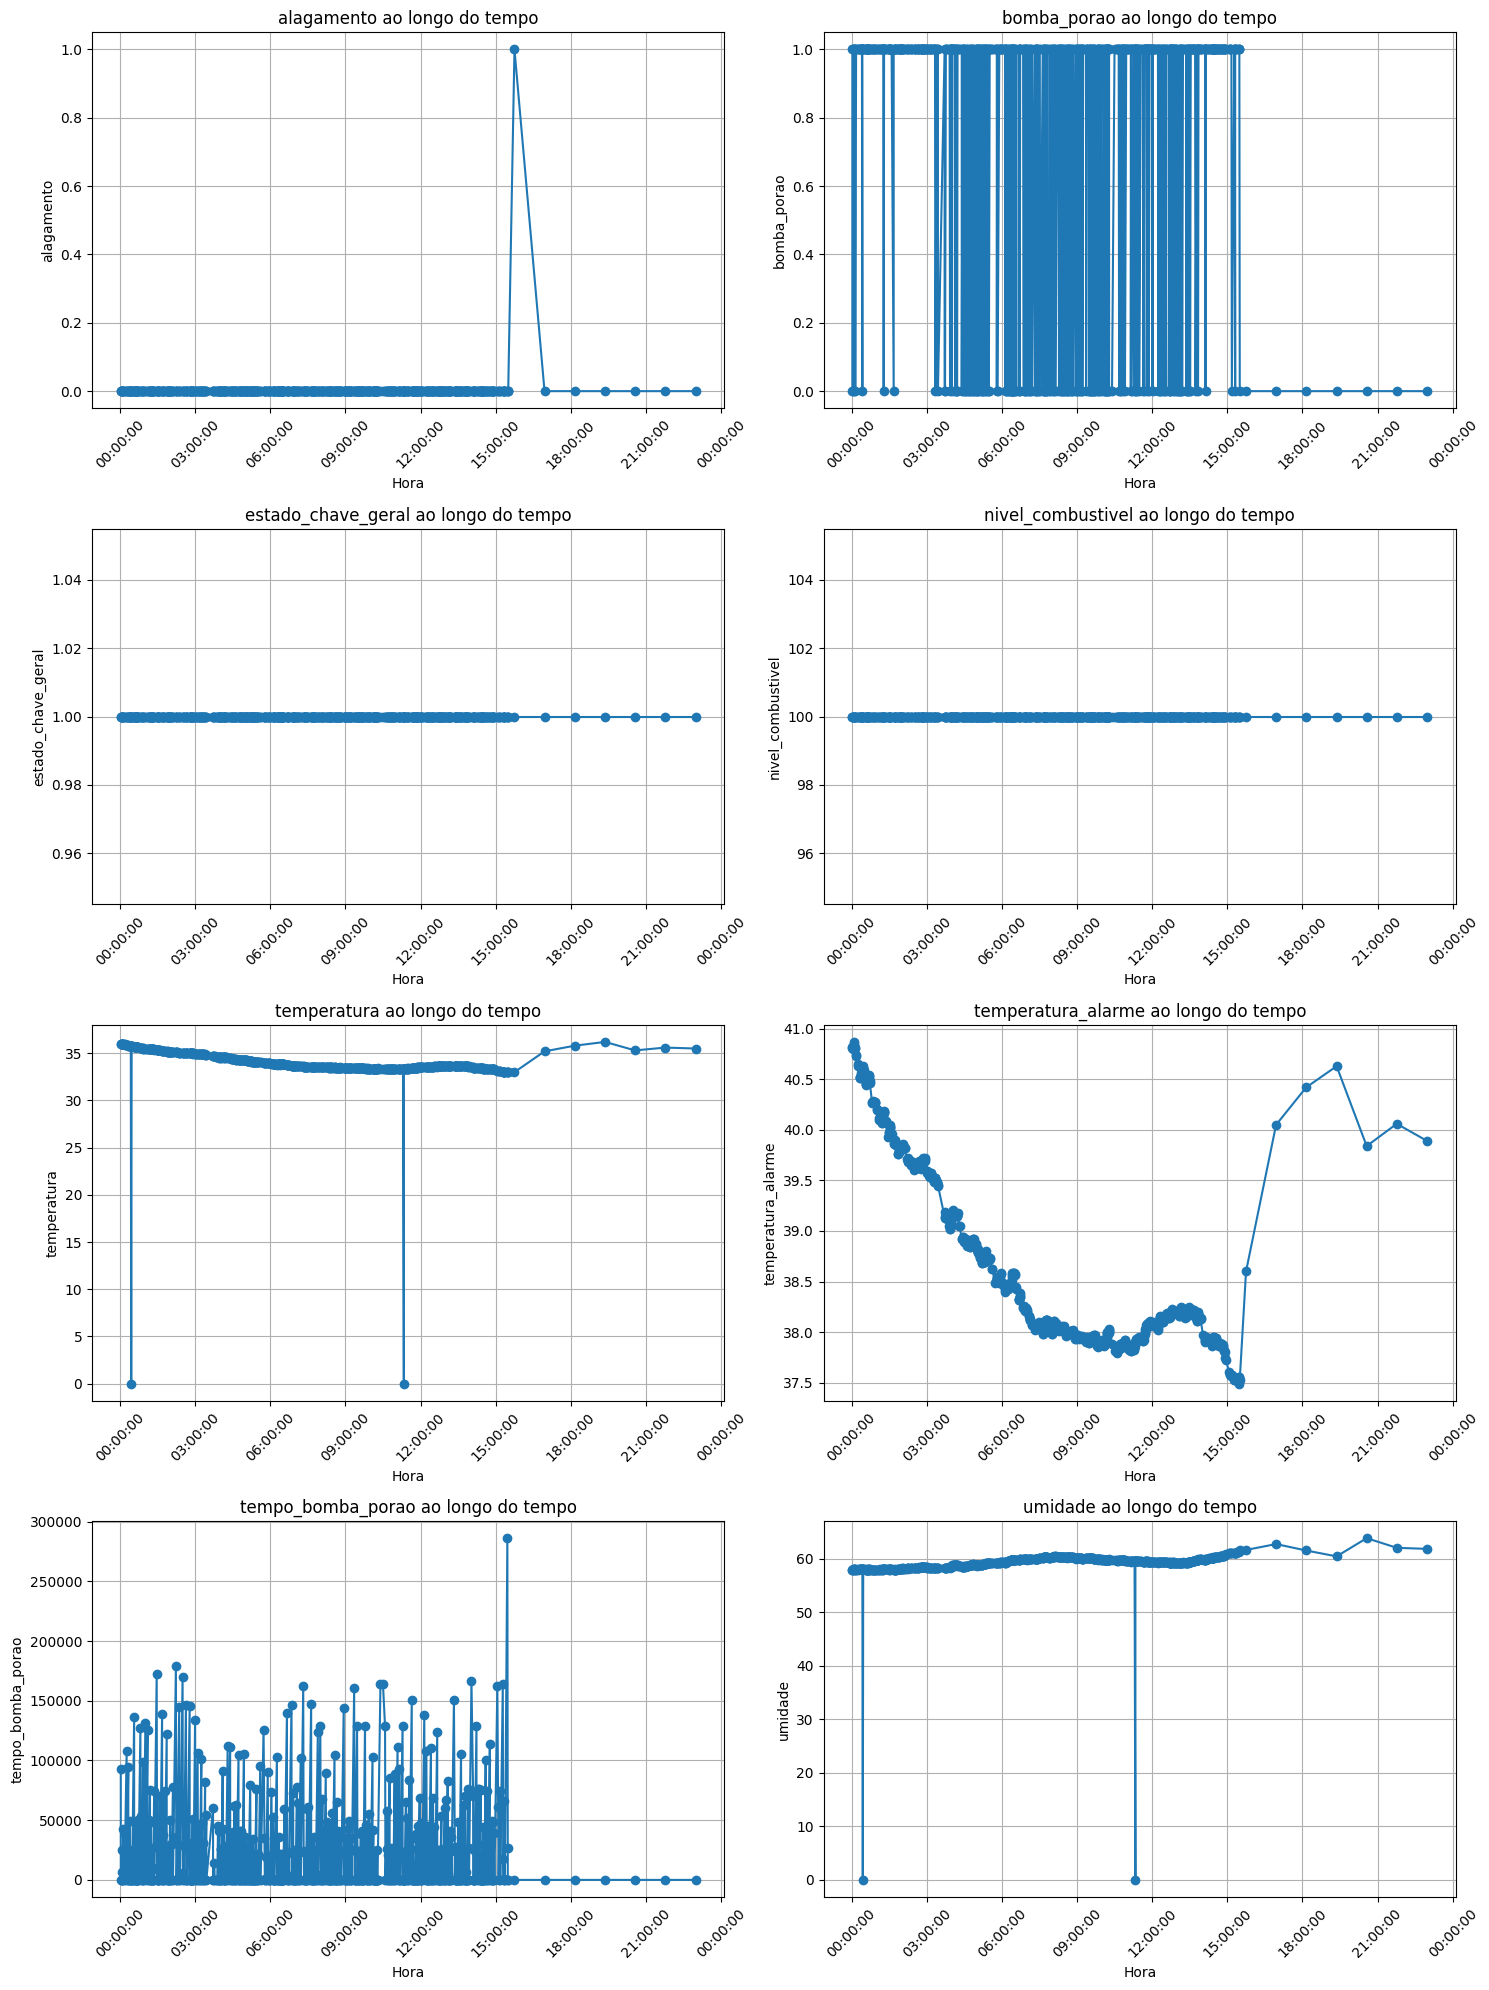

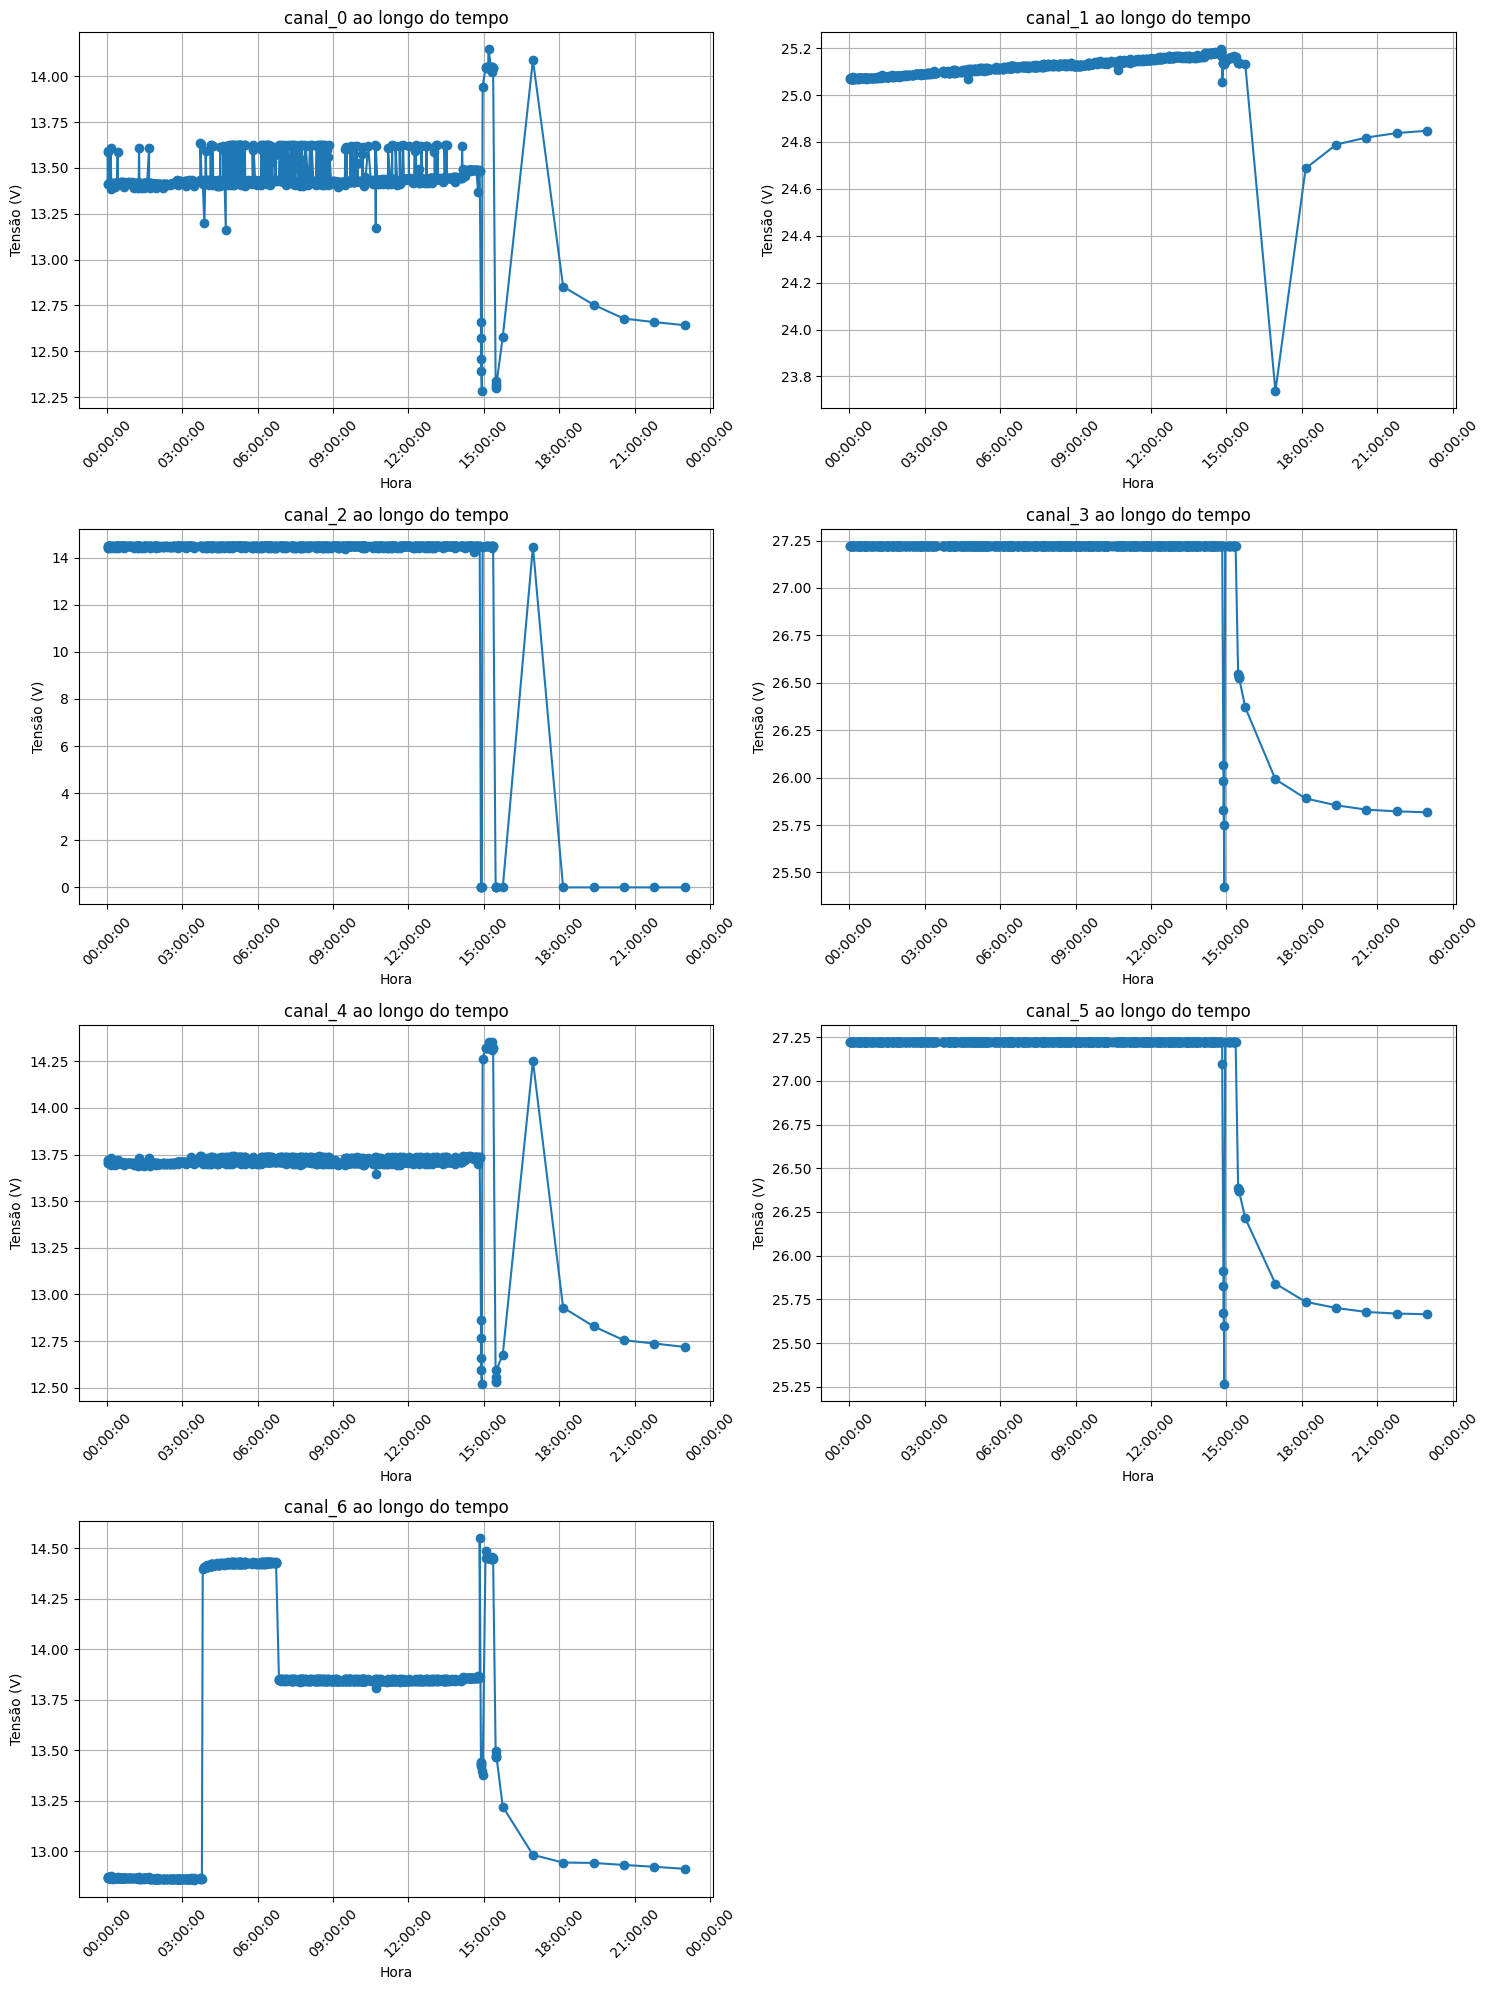

In [5]:
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import folium
import math

records = []
for key, value in data.items():
    record = {}
    try:
        record['hora'] = value['rastreamento']['hora']
        record['intensidade_sinal_dBM'] = float(value['rastreamento']['intensidade_sinal_dBM'])
        posicao = value['rastreamento']['posicao']
        lat, lon = [float(coord) for coord in posicao.split(',')]
        record['latitude'] = lat
        record['longitude'] = lon
    except:
        continue

    try:
        for sensor_key, sensor_value in value['sensores'].items():
            try:
                record[sensor_key] = float(sensor_value)
            except ValueError:
                record[sensor_key] = sensor_value
    except:
        pass

    try:
        for tensao_key, tensao_value in value['tensoes'].items():
            try:
                record[tensao_key] = float(tensao_value)
            except ValueError:
                record[tensao_key] = tensao_value
    except:
        pass

    records.append(record)


df = pd.DataFrame(records)
df['hora'] = pd.to_datetime(df['hora'], format='%H:%M')
sensor_variables = ['alagamento', 'bomba_porao', 'estado_chave_geral', 'nivel_combustivel',
                    'temperatura', 'temperatura_alarme', 'tempo_bomba_porao', 'umidade']
sensor_variables = [var for var in sensor_variables if var in df.columns]


num_sensors = len(sensor_variables)
cols = 2
rows = math.ceil(num_sensors / cols)
fig, axs = plt.subplots(rows, cols, figsize=(15, 5*rows))
axs = axs.flatten()

for i, sensor in enumerate(sensor_variables):
    ax = axs[i]
    ax.plot(df['hora'], df[sensor], marker='o')
    ax.tick_params(axis='x', labelrotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%X'))
    ax.set_title(f'{sensor} ao longo do tempo')
    ax.set_xlabel('Hora')
    ax.set_ylabel(sensor)
    ax.grid(True)

# Remover subplots não utilizados
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

tensao_variables = [col for col in df.columns if col.startswith('canal_')]

num_tensoes = len(tensao_variables)
cols = 2
rows = math.ceil(num_tensoes / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, 5*rows))
axs = axs.flatten()

for i, tensao in enumerate(tensao_variables):
    ax = axs[i]
    ax.plot(df['hora'], df[tensao], marker='o')
    ax.tick_params(axis='x', labelrotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%X'))
    ax.set_title(f'{tensao} ao longo do tempo')
    ax.set_xlabel('Hora')
    ax.set_ylabel('Tensão (V)')
    ax.grid(True)

# Remover subplots não utilizados
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [ ]:
map_center = [df['latitude'].mean(), df['longitude'].mean()]
plot_map = folium.Map(location=map_center, zoom_start=13)
coords = list(zip(df['latitude'], df['longitude']))
folium.PolyLine(coords, color="blue", weight=2.5, opacity=1).add_to(plot_map)
for idx, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=(f"Hora: {row['hora'].strftime('%H:%M')}\n"
               f"Temperatura Alarme: {row['temperatura_alarme']}°C"),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(plot_map)
plot_map